# Exploratory Data Analysis (EDA)

(450, 104)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Columns: 104 entries, id to CS.std
dtypes: bool(1), float64(100), int64(1), object(2)
memory usage: 362.7+ KB
None
             count        mean         std         min         25%  \
id           450.0  224.500000  130.048068    0.000000  112.250000   
CO2168.mean  450.0  382.077392   11.168050  359.086782  373.872136   
CO2168.std   450.0    3.352010    3.448155    0.120513    0.974968   
CO2336.mean  450.0  382.102391   11.132140  359.427989  373.861228   
CO2336.std   450.0    3.157262    3.190584    0.088273    0.940732   
...            ...         ...         ...         ...         ...   
UV_A.std     450.0    7.613890    4.946876    0.121475    2.700430   
UV_B.mean    450.0    0.442398    0.317924    0.007546    0.138079   
UV_B.std     450.0    0.379078    0.285288    0.002685    0.106026   
CS.mean      450.0    0.003083    0.002246    0.000343    0.001436   
CS.std       450.0    0.000692  

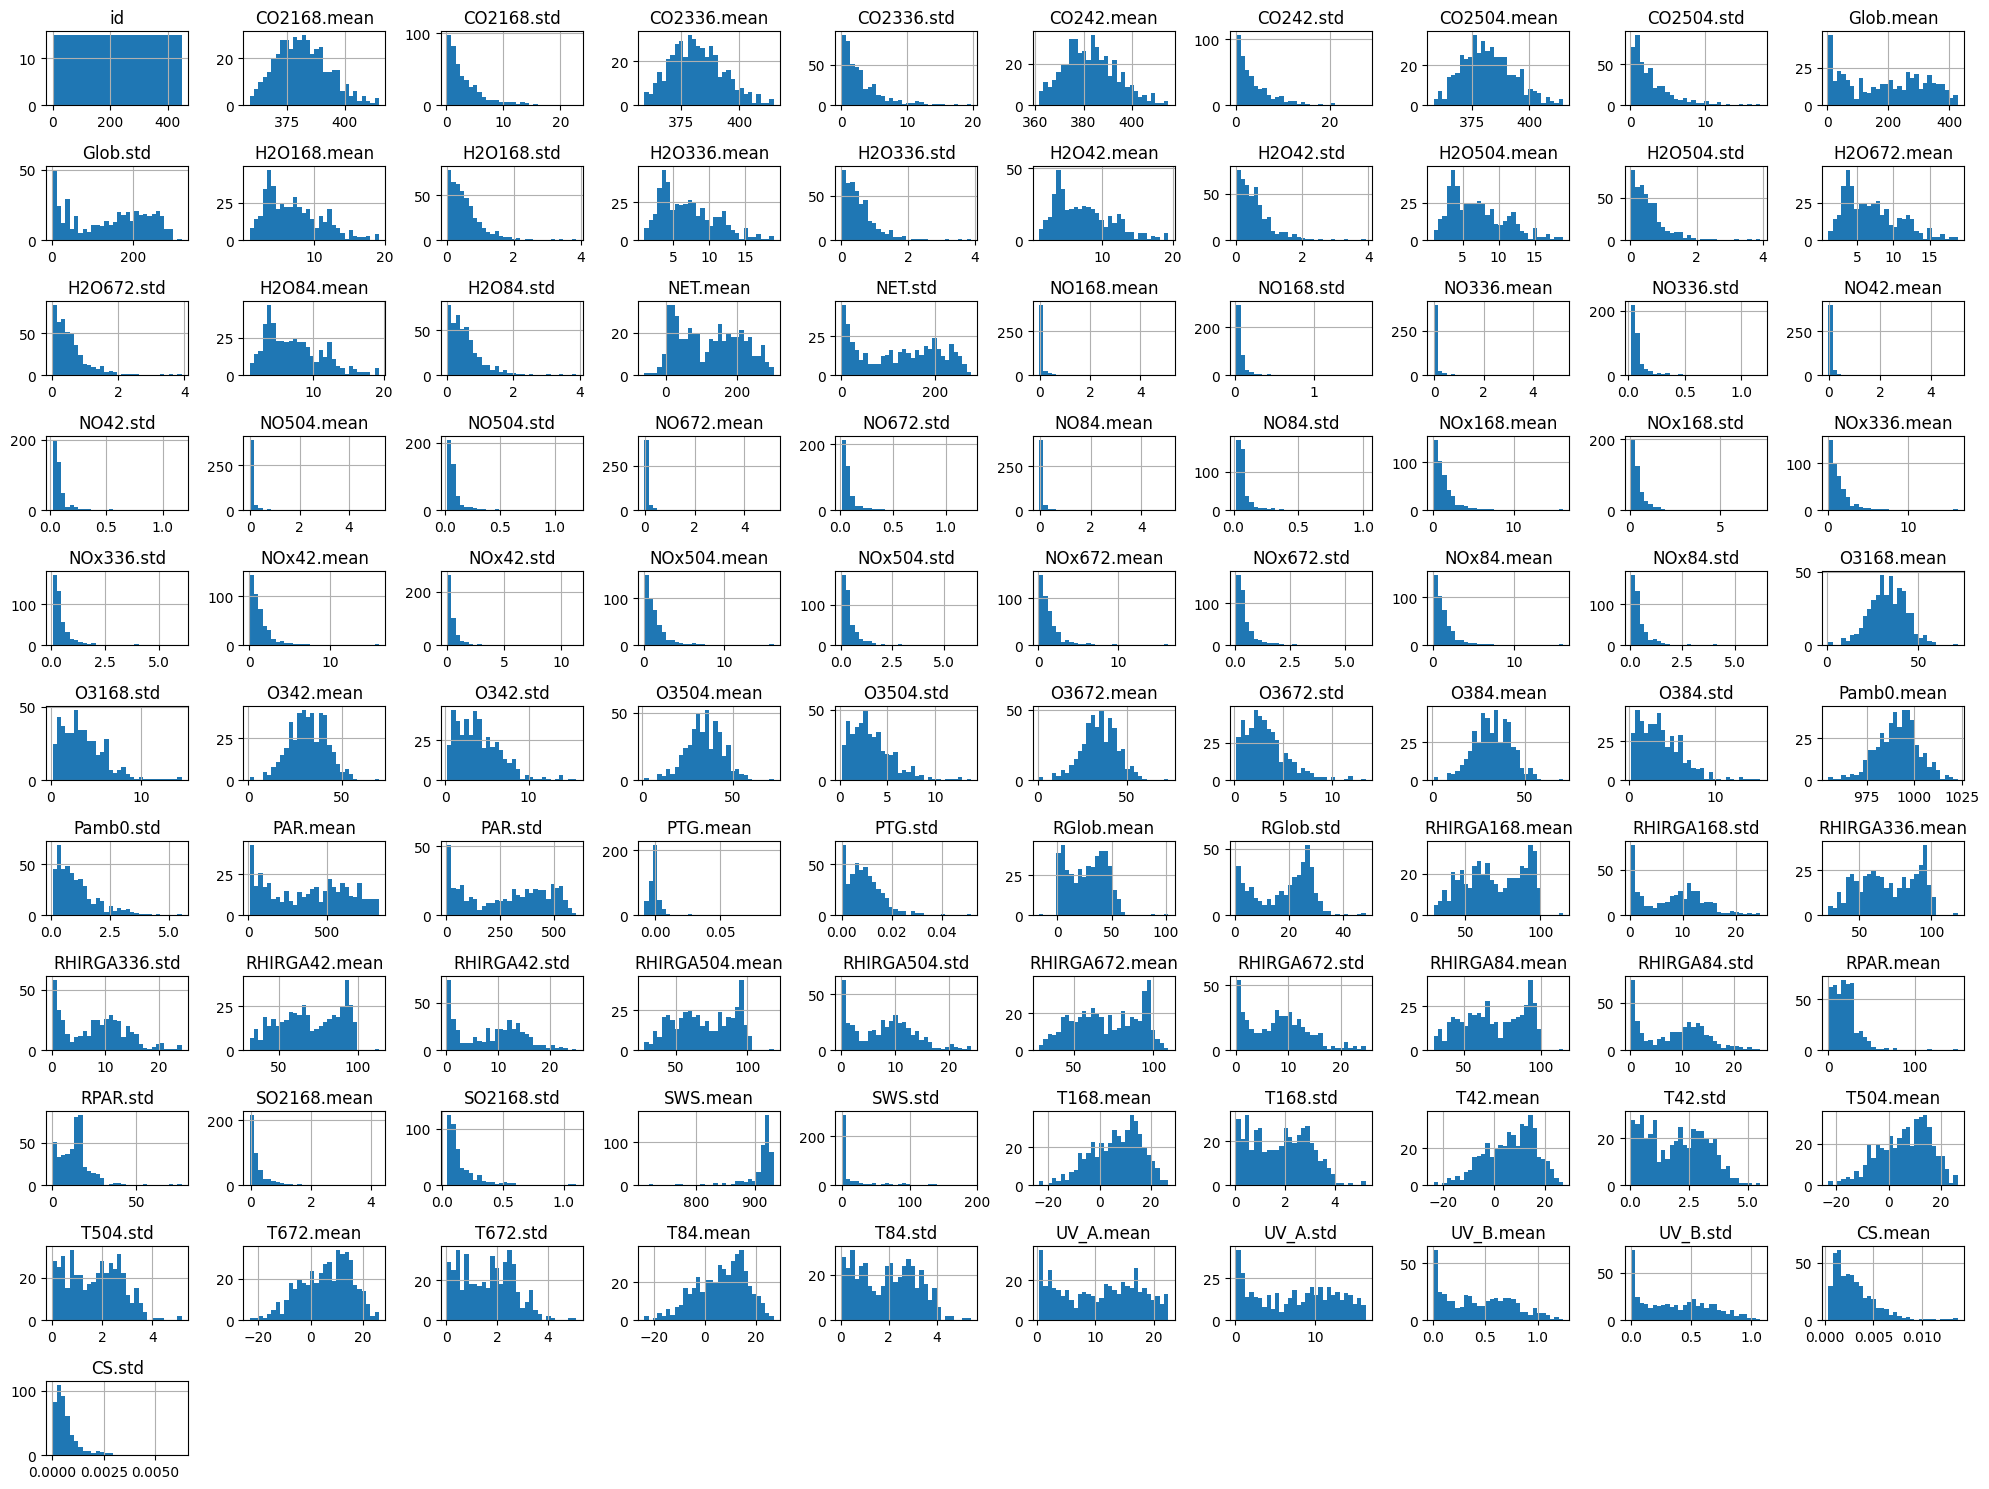

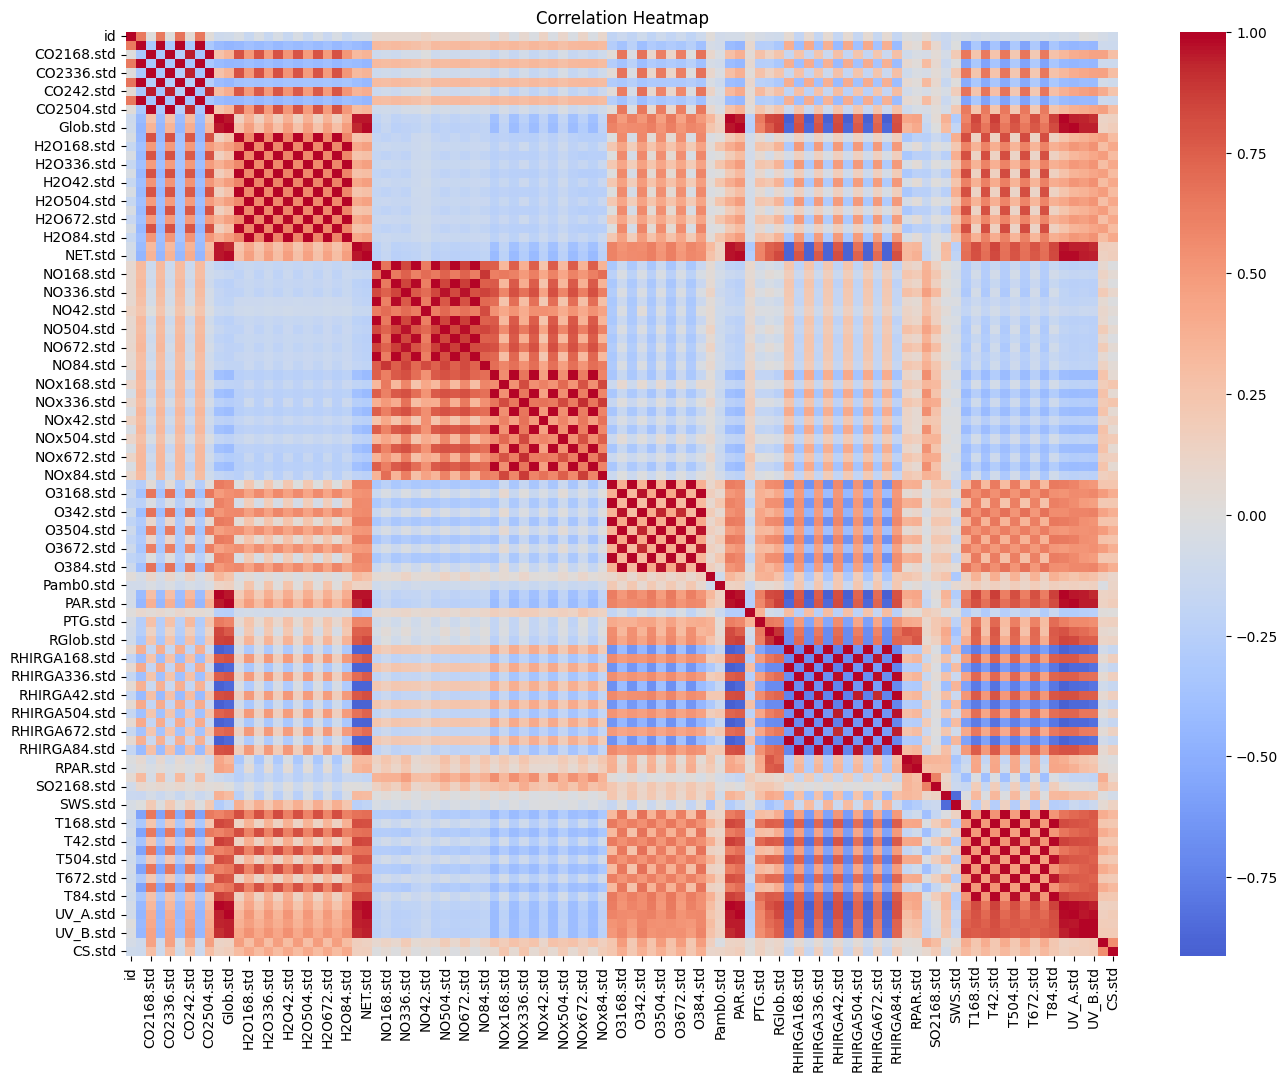

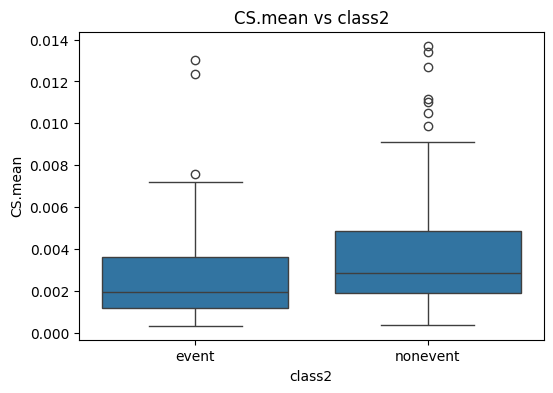

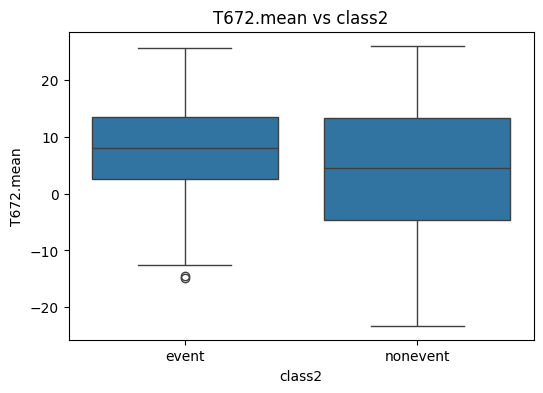

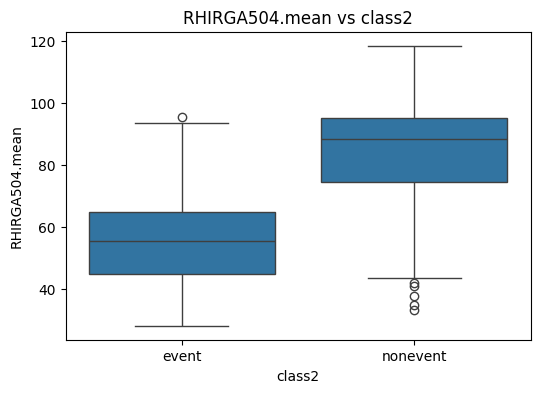

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Load data
train = pd.read_csv("train.csv")

# Basic info
print(train.shape)
print(train.info())
print(train.describe().T)

# Class distribution
print(train['class4'].value_counts())
train['class2'] = train['class4'].apply(lambda x: 'nonevent' if x=='nonevent' else 'event')
print(train['class2'].value_counts())

# Histograms
train.hist(figsize=(20,15), bins=30)
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric columns only)
numeric_cols = train.select_dtypes(include=[np.number])
plt.figure(figsize=(16, 12))
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

# Boxplots (example features)
features_to_check = ['CS.mean', 'T672.mean', 'RHIRGA504.mean']

for f in features_to_check:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=train, x='class2', y=f)
    plt.title(f"{f} vs class2")
    plt.show()


# Preprocessing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop ID
train = train.drop(columns=['id'])

# Create binary class
train['class2'] = train['class4'].apply(lambda x: 'nonevent' if x=='nonevent' else 'event')

# Convert date to datetime for EDA (not used in model)
train['date'] = pd.to_datetime(train['date'])

# Feature matrix & targets
X = train.drop(columns=['class4', 'class2', 'date'])
y2 = train['class2']  # binary target

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y2, test_size=0.2, stratify=y2, random_state=42
)

# Scaling (for LR & GB)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(
    max_iter=60,
    class_weight='balanced',
    solver='lbfgs'
)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_val_scaled)
acc_lr = accuracy_score(y_val, y_pred_lr)

print("Logistic Regression Accuracy:", acc_lr)


Logistic Regression Accuracy: 0.8666666666666667


# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)   # raw features (not scaled)

y_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)

print("Random Forest Accuracy:", acc_rf)


Random Forest Accuracy: 0.8333333333333334


# Gradient Boosting

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_val_scaled)
acc_gb = accuracy_score(y_val, y_pred_gb)

print("Gradient Boosting Accuracy:", acc_gb)


Gradient Boosting Accuracy: 0.8444444444444444


# Model Comparison with 5-Fold Cross-Validation

In [6]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3)
}

print("\n===== 5-Fold Cross-Validation Results =====")
for name, model in models.items():
    if name == "Logistic Regression" or name == "Gradient Boosting":
        scores = cross_val_score(model, scaler.fit_transform(X), y2, cv=5, scoring='accuracy')
    else:
        scores = cross_val_score(model, X, y2, cv=5, scoring='accuracy')

    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")



===== 5-Fold Cross-Validation Results =====
Logistic Regression: mean=0.8756, std=0.0325
Random Forest: mean=0.8578, std=0.0083
Gradient Boosting: mean=0.8644, std=0.0147


# Train FINAL Logistic Regression on All Training Data

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Prepare full training set
X_full = X  # all processed features (drop id, date, labels)
y_full = y2  # class2

# Scale using ALL data
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X_full)

# Train final model
final_lr = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)
final_lr.fit(X_full_scaled, y_full)

print("Final Logistic Regression trained successfully.")


Final Logistic Regression trained successfully.


# Predict Probabilities (for perplexity)

In [8]:
# Probabilities for class2 (event)
proba_full = final_lr.predict_proba(X_full_scaled)[:, 1]
proba_full[:10]

array([0.00711111, 0.06809011, 0.00214706, 0.0026072 , 0.93823019,
       0.37030254, 0.02254264, 0.04898807, 0.39315771, 0.11190433])

# Probability Calibration

In [9]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_lr = CalibratedClassifierCV(
    final_lr,
    method="sigmoid",  # Platt scaling
    cv=5
)

calibrated_lr.fit(X_full_scaled, y_full)

,estimator,LogisticRegre...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [10]:
proba_calibrated = calibrated_lr.predict_proba(X_full_scaled)[:, 1]
proba_calibrated[:10]

array([0.02875902, 0.12892219, 0.01131731, 0.01407516, 0.86060791,
       0.40265763, 0.06664755, 0.09387432, 0.40305591, 0.16605891])

# Multi-Class Modeling for class4

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

y4 = train['class4']

final_lr4 = OneVsRestClassifier(
    LogisticRegression(max_iter=5000, class_weight='balanced')
)

final_lr4.fit(X_full_scaled, y4)

,estimator,LogisticRegre...max_iter=5000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


In [12]:
class4_pred_full = final_lr4.predict(X_full_scaled)

# KAGGLE SUBMISSION PIPELINE

In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier



In [14]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Preprocess train

In [15]:
# Drop id (not useful for model)
train = train.drop(columns=['id'])

# Create binary label class2
train['class2'] = train['class4'].apply(lambda x: 'nonevent' if x=='nonevent' else 'event')

# Convert date to datetime for train (not used in model)
train['date'] = pd.to_datetime(train['date'])

# Features and labels
X = train.drop(columns=['class4', 'class2', 'date'])
y2 = train['class2']
y4 = train['class4']

## Preprocess test in the same way

In [16]:
test_ids = test['id']

# Drop id
test = test.drop(columns=['id'])

# Convert date (your dates are empty but safe to run)
test['date'] = pd.to_datetime(test['date'], errors='coerce')

# Drop date
X_test = test.drop(columns=['date'])

## Fit scaler on all training data

In [17]:
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

## Train final Logistic Regression (class2)

In [18]:
final_lr = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)

final_lr.fit(X_full_scaled, y2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


## Calibrate probabilities (for perplexity)

In [19]:
calibrated_lr = CalibratedClassifierCV(
    final_lr,
    method="sigmoid",
    cv=5
)
calibrated_lr.fit(X_full_scaled, y2)

,estimator,LogisticRegre...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


## Predict class2 labels + probs on test

In [20]:
test_proba_class2 = calibrated_lr.predict_proba(X_test_scaled)[:, 1]
test_pred_class2 = calibrated_lr.predict(X_test_scaled)

In [21]:
test_pred_class2 = pd.Series(test_pred_class2, index=test_ids.index)

## Train Multi-Class Model for class4 (One-vs-Rest LR)

In [22]:
final_lr4 = OneVsRestClassifier(
    LogisticRegression(max_iter=5000, class_weight='balanced')
)
final_lr4.fit(X_full_scaled, y4)


,estimator,LogisticRegre...max_iter=5000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


## Predict class4 on test

In [23]:
test_pred_class4 = final_lr4.predict(X_test_scaled)
test_pred_class4 = pd.Series(test_pred_class4, index=test_ids.index)

## Build Submission File

In [24]:
# p = probability of event (class2)
# class4 = predicted class4 multi-class label

submission = pd.DataFrame({
    'id': test_ids,
    "class4": test_pred_class4,
    "p": test_proba_class2
})


## Save submission

In [25]:
submission.to_csv("submission.csv", index=False)
print("Correct submission.csv created!")

Correct submission.csv created!


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ================================================
# 1) CREATE VALIDATION SPLIT PROPERLY
# ================================================
X_train, X_val, y2_train, y2_val, y4_train, y4_val = train_test_split(
    X, y2, y4,
    test_size=0.2,
    random_state=42,
    stratify=y4
)

# ================================================
# 2) SCALE (fit on training only)
# ================================================
scaler_val = StandardScaler()
X_train_scaled = scaler_val.fit_transform(X_train)
X_val_scaled   = scaler_val.transform(X_val)

# ================================================
# 3) TRAIN MODELS ON TRAIN SPLIT ONLY
# ================================================
final_lr_val = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)
final_lr_val.fit(X_train_scaled, y2_train)

calibrated_lr_val = CalibratedClassifierCV(
    final_lr_val,
    method="sigmoid",
    cv=5
)
calibrated_lr_val.fit(X_train_scaled, y2_train)

# 4-class model
final_lr4_val = OneVsRestClassifier(
    LogisticRegression(max_iter=5000, class_weight='balanced')
)
final_lr4_val.fit(X_train_scaled, y4_train)

# ================================================
# 4) PREDICT ON VALIDATION SPLIT
# ================================================
val_pred_class4 = final_lr4_val.predict(X_val_scaled)
val_pred_p = calibrated_lr_val.predict_proba(X_val_scaled)[:, 1]


In [28]:
def kaggle_score(solution_true_class4, submission_pred_class4, submission_pred_p):
    sol4 = np.array(solution_true_class4)
    pred4 = np.array(submission_pred_class4)
    p = np.array(submission_pred_p)

    sol2 = sol4 != "nonevent"
    pred2 = pred4 != "nonevent"

    binary_acc = np.mean(sol2 == pred2)

    p_i = np.where(sol2, p, 1 - p)
    p_i = np.clip(p_i, 1e-15, 1 - 1e-15)
    perplexity = np.exp(-np.mean(np.log(p_i)))

    norm_perp = max(0, min(1, 2 - perplexity))

    mc_acc = np.mean(sol4 == pred4)

    score = (binary_acc + mc_acc + norm_perp) / 3

    return binary_acc, perplexity, mc_acc, score


In [29]:
bin_acc, perp, mc_acc, score = kaggle_score(
    y4_val,
    val_pred_class4,
    val_pred_p
)

print("====== Local Kaggle-Style Validation Score ======")
print(f"Binary accuracy:        {bin_acc:.5f}")
print(f"Perplexity:             {perp:.5f}")
print(f"Multiclass accuracy:    {mc_acc:.5f}")
print("-------------------------------------------------")
print(f"Estimated Kaggle Score: {score:.5f}")
print("=================================================")


====== Local Kaggle-Style Validation Score ======
Binary accuracy:        0.87778
Perplexity:             8.46367
Multiclass accuracy:    0.63333
-------------------------------------------------
Estimated Kaggle Score: 0.50370
